# 1. Preprocess data set and performing EDA

In this section we have described how we will preprocess data set by reading files from S3
- Input: S3 files in csv format 
- Output: Preprocess data which can be used for model training 

In [1]:
# Importing required library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Setting dataframe display options

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Reading and importing data set

In [3]:
# # you can put any value here according to your situation
# chunksize = 10000

# # the list that contains all the dataframes
# list_of_dataframes = []

# for df in pd.read_csv('s3://poc-sagemaker-step-function-bucketformodelanddata-iip9wy7qh0y0/vci/data/input/vehicles.csv', chunksize=chunksize):
#     # process your data frame here
#     # then add the current data frame into the list
#     list_of_dataframes.append(df)

# # if you want all the dataframes together, here it is
# data = pd.concat(list_of_dataframes)

In [4]:
data = pd.read_csv("s3://ds-mlops-s3/data/input/inputdata.csv",
                   nrows=50000)

In [ ]:
import pandas as pd
#start = time.time()
#read data in chunks of 1 million rows at a time
iter_csv = pd.read_csv('s3://wi-cred-datalake-dev-raw/data/input/offlease/vehicles.csv',iterator=True,chunksize=100000)
#end = time.time()
#print("Read csv with chunks: ",(end-start),"sec")
df = pd.concat([chunk[chunk['VIN'].str.slice(start=-1).isin(['2', '3', '4', '5'])] for chunk in iter_csv])
#pd_df = pd.concat(chunk)
#Read csv with chunks:  0.013001203536987305 sec
#import pandas as pd
#chunksize = 10000
#data = pd.read_csv('s3://wi-cred-datalake-dev-raw/data/input/offlease/vehicles.csv',chunksize=chunksize)

In [6]:
df.shape

(26501, 26)

describing dataset which we have got

In [6]:
df.describe()


Unnamed: 0            id         price          year      odometer  \
count  50000.000000  5.000000e+04  5.000000e+04  49840.000000  4.312100e+04   
mean   24999.500000  7.235423e+09  9.737749e+04   2010.917095  8.808795e+04   
std    14433.901067  4.511320e+06  1.371922e+07      9.541836  1.314989e+05   
min        0.000000  7.218892e+09  0.000000e+00   1900.000000  0.000000e+00   
25%    12499.750000  7.232401e+09  5.800000e+03   2008.000000  3.650000e+04   
50%    24999.500000  7.236879e+09  1.298900e+04   2013.000000  7.612600e+04   
75%    37499.250000  7.239370e+09  2.350000e+04   2017.000000  1.216810e+05   
max    49999.000000  7.240698e+09  2.808349e+09   2021.000000  1.000000e+07   

                lat          long  
count  49836.000000  49836.000000  
mean      37.191616   -112.459686  
std        7.291648     16.726134  
min      -79.809640   -160.884673  
25%       33.743904   -120.995406  
50%       34.601900   -117.489706  
75%       37.737407    -95.751970  
max       64.993698    150.898969

Removing unnessary columns

In [7]:
df.drop(columns=['Unnamed: 0', 'id', 'url', 'region', 
                 'region_url', 
                 'VIN', 'size', 'image_url', 
                 'description', 'state', 'lat', 'long'], inplace=True)

Imputing data for missing values

In [8]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(strategy='mean')
imr = imr.fit(df[['odometer']])
imputed_data = imr.transform(df[['odometer']])
df['odometer'] = pd.DataFrame(imputed_data)
df['odometer'].head()

0     32742.0
1     93600.0
2     87046.0
3    190000.0
4    116000.0
Name: odometer, dtype: float64

In [9]:
df['price'].value_counts

<bound method IndexOpsMixin.value_counts of 0        35990
1         7500
2         4900
3         2000
4        19500
         ...  
49995    25995
49996    27490
49997    10499
49998    21995
49999    26980
Name: price, Length: 50000, dtype: int64>

In [10]:
from sklearn import preprocessing

def encode_features(dataframe):
    result = dataframe.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_df, encoders = encode_features(df) 
encoded_df.head()

price    year  manufacturer  model  condition  cylinders  fuel  odometer  \
0  35990  2010.0             7   2761          2          6     2   32742.0   
1   7500  2014.0            17   6919          0          3     2   93600.0   
2   4900  2006.0             4   7957          2          5     2   87046.0   
3   2000  1974.0             7   2117          2          3     2  190000.0   
4  19500  2005.0            13   3958          0          6     0  116000.0   

   title_status  transmission  drive  type  paint_color  posting_date  
0             0             2      2     7           12         45683  
1             0             0      1     9           12         44930  
2             0             0      3     0            1         44542  
3             0             0      2     8            1         43200  
4             1             0      0     8            1         42054

Features' hists plotted


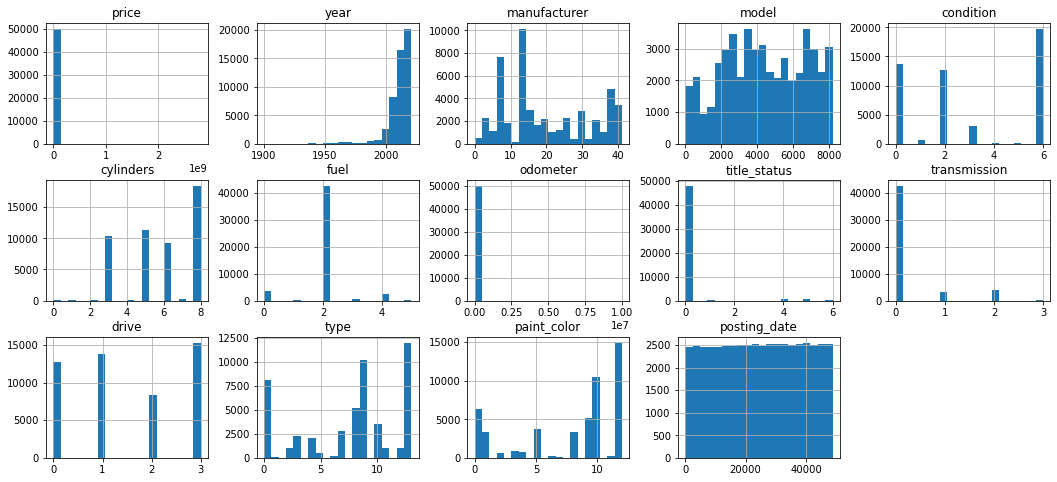

In [11]:
encoded_df.hist(figsize=(18, 8), layout=(3,5), bins=20)
print('Features\' hists plotted')

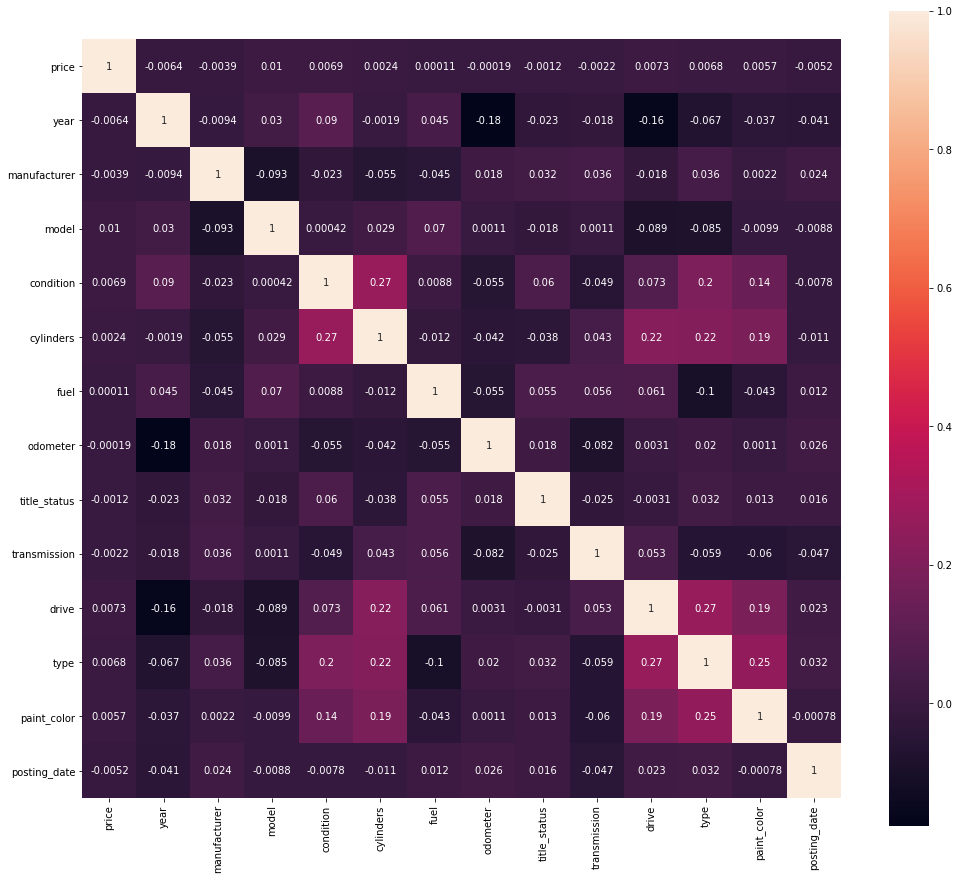

In [12]:
plt.subplots(figsize=(17, 15))
sns.heatmap(encoded_df.corr(), square = True, annot=True)
plt.show()

In [13]:
encoded_df.head()

price    year  manufacturer  model  condition  cylinders  fuel  odometer  \
0  35990  2010.0             7   2761          2          6     2   32742.0   
1   7500  2014.0            17   6919          0          3     2   93600.0   
2   4900  2006.0             4   7957          2          5     2   87046.0   
3   2000  1974.0             7   2117          2          3     2  190000.0   
4  19500  2005.0            13   3958          0          6     0  116000.0   

   title_status  transmission  drive  type  paint_color  posting_date  
0             0             2      2     7           12         45683  
1             0             0      1     9           12         44930  
2             0             0      3     0            1         44542  
3             0             0      2     8            1         43200  
4             1             0      0     8            1         42054

In [14]:
# encoded_df.to_csv('encoded_df.csv', encoding='utf-8')

We'll then split the dataset into training (70%), validation (20%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation datasets during training. Test dataset will be used to evaluate model performance after it is deployed to an endpoint.

Amazon SageMaker's XGBoost algorithm expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [15]:
train_data, validation_data, test_data = np.split(encoded_df.sample(frac=1, random_state=1729), [int(0.7 * len(encoded_df)), int(0.9*len(encoded_df))])  

In [16]:
train_data.shape

(35000, 14)

In [17]:
validation_data.shape

(10000, 14)

In [18]:
test_data.shape

(5000, 14)

In [62]:
test_data.head(1)

price    year  manufacturer  model  condition  cylinders  fuel  \
31377  15788  2012.0            23   4778          6          5     2   

       odometer  title_status  transmission  drive  type  paint_color  \
31377   72612.0             0             0      2     9            8   

       posting_date  
31377         35337

**Exporting data set to s3 bucket without header**

In [19]:
train_data.to_csv('s3://ds-mlops-s3/preprocess-data/train/train.csv', index=False, header=False)
validation_data.to_csv('s3://ds-mlops-s3/preprocess-data/validation/validation_data.csv', index=False, header=False)
test_data.to_csv('s3://ds-mlops-s3/preprocess-data/test/test.csv', index=False, header=False)

## 2. Building model

In this section we will decribe how we will build model with XGboost inbuilt model and here we will pass hyperparameter to train our model

In [20]:
# Importing the required libraries
import boto3
import time
from time import gmtime, strftime
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import datetime
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.inputs import TrainingInput

# hyper
job_name = 'ds-mlops-xgboost' + str(datetime.datetime.now().timestamp()).split('.')[0]

# sagemaker
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#ec2
Instance_Type = "ml.m5.xlarge"
VolumeSizeIn_GB = 1
Instance_Count = 1

#setup container
container = get_image_uri(region, "xgboost", "1.2-1")

#s3
bucket = "ds-mlops-s3"
prefix = "ds-mlops-s3/preprocess-data"
# 
#input
data_bucket = bucket
data_prefix = prefix
data_bucket_path = f"s3://{data_bucket}"

# S3 bucket for saving code and model artifacts.
# output
output_bucket = sagemaker.Session().default_bucket()
output_prefix = 'ds-mlops-s3/output'
output_bucket_path = f"s3://{output_bucket}"  

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---

## Setup_Hyperparameter_Tuning 
*Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.*


Now that we have prepared the dataset, we are ready to train models. Before we do that, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, which includes:
* The container image for the algorithm (XGBoost)
* Configuration for the output of the training jobs
* The values of static algorithm hyperparameters, those that are not specified will be given default values
* The type and number of instances to use for the training jobs

In [21]:
#setup sagemaker SDK
client = boto3.client("sagemaker", region_name=region)

In [22]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='{}/{}'.format(data_bucket_path, 'output/'),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='rmse',
                        objective='reg:squarederror',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

We will tune four hyperparameters in this examples:
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* *alpha*: L1 regularization term on weights. Increasing this value makes models more conservative. 
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

In [23]:
hyperparameter_ranges = {'max_depth': IntegerParameter(4, 8)}

# Tunable parameters: colsample_bytree, lambda, eta, max_depth, alpha, colsample_bynode, num_round, colsample_bylevel, subsample, min_child_weight, max_delta_step, gamma

# hyperparameter_ranges = {'eta': ContinuousParameter(0.1, 1),
#                        'min_child_weight': ContinuousParameter(5, 20),
#                        'alpha': ContinuousParameter(0.1, 1),
#                        'max_depth': IntegerParameter(5, 8),
#                        'gamma':IntegerParameter(2, 4)}

# grid = {'n_estimators': [50, 150], 
#         'learning_rate': [0.01, 0.1],
#         'max_depth': [4, 7],
#         'reg_lambda': [0.5]}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [24]:
objective_metric_name = 'validation:accuracy'

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The XGBoost estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [25]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=5,
                            max_parallel_jobs=1)

## Launch_Hyperparameter_Tuning
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [26]:
s3_input_train = TrainingInput(s3_data='{}/preprocess-data/train/train.csv'.format(data_bucket_path, data_prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='{}/preprocess-data/validation/validation_data.csv'.format(data_bucket_path, data_prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

...............................................................................................................................................................................................................................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [27]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [28]:
tuning_job_name = tuner.latest_tuning_job.job_name # Get name of hpo job

# Analyze Results of a Hyperparameter Tuning job

Once you have completed a tuning job, (or even while the job is still running) you can use this notebook to analyze the results to understand how each hyperparameter effects the quality of the model.


## Track hyperparameter tuning job progress and print best result
After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [29]:
# run this cell to check current status of hyperparameter tuning job
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)


status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)

best_hyper_parameter = tuning_job_result['BestTrainingJob']['TunedHyperParameters']
print("Best performing hyper parameters :",best_hyper_parameter)

result = tuning_job_result['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']
print("Result : ",result)

5 training jobs have completed
Best performing hyper parameters : {'max_depth': '7'}
Result :  {'MetricName': 'validation:accuracy', 'Value': 0.007499999832361937}


In [30]:
%store best_hyper_parameter

Stored 'best_hyper_parameter' (dict)


**Creating model for XGBoost by passing hyper parameter**

Once we have tunned parameter we will generate our model for scoring activities on sagemaker

In [31]:
{output_bucket_path},{output_prefix}

({'s3://sagemaker-us-east-1-014257795134'}, {'ds-mlops-s3/output'})

In [32]:
%%time

print("Training job", job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"{output_bucket_path}/{output_prefix}/output"},
    "ResourceConfig": {"InstanceCount": Instance_Count, "InstanceType": Instance_Type, "VolumeSizeInGB": VolumeSizeIn_GB},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth": "7",
        "alpha": "0.2361716532175895",
        "gamma": "5",
        "min_child_weight": "10",
        "eta": "0.6965651174349499",
        "objective": "reg:squarederror",
        "num_round":"100"
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://ds-mlops-s3/preprocess-data/train/train.csv",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://ds-mlops-s3/preprocess-data/validation/validation_data.csv",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
        },
    ],
}

client.create_training_job(**create_training_params)

#track execution
status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)

Training job ds-mlops-xgboost1625839453
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 96 ms, sys: 606 µs, total: 96.6 ms
Wall time: 4min 1s


In [33]:
# checking training job status after creating training job
status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)

Completed


In [34]:
# printing model output location
print(f"model path: >> {output_bucket_path}/{output_prefix}/output")

model path: >> s3://sagemaker-us-east-1-014257795134/ds-mlops-s3/output/output


In [35]:
# printing the training metrics you can tune and generate model as per need
metrics = client.describe_training_job(TrainingJobName=job_name)["FinalMetricDataList"]
print(metrics)

[{'MetricName': 'train:rmse', 'Value': 150169.3125, 'Timestamp': datetime.datetime(2021, 7, 9, 14, 34, 44, tzinfo=tzlocal())}, {'MetricName': 'validation:rmse', 'Value': 2711492.75, 'Timestamp': datetime.datetime(2021, 7, 9, 14, 34, 44, tzinfo=tzlocal())}]


In [36]:
# finding job name 
print(job_name)

ds-mlops-xgboost1625839453


**Note:** you will need folowing values in next section
- hyperparameter
- training job name

## 3. Generate model on Sagemaker

In section we will describe how we can create a model with our training jobs

In [37]:
import sys
import math
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from time import gmtime, strftime

model_name = 'ds-mlops-xgboost' # It need to be unique across the account

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", 
                              region_name=region)
client = boto3.client("sagemaker", 
                      region_name=region)

Check if model with same name exists or not. If it exist then delete it.

In [38]:
client = boto3.client('sagemaker') # getting sagemaker client 
try:
    client.delete_model(
        ModelName='ds-mlops-xgboost' # delete if some model exist with this name
    )
except:
    pass

In [39]:
container = get_image_uri(region, "xgboost", "1.2-1") # getting container image

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


**Register model**


In [40]:
# Here we are registering our model
print(model_name) 
info = client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)
primary_container = {"Image": container, "ModelDataUrl": model_data}
create_model_response = client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)
print(create_model_response["ModelArn"]) # printing model ARN which is cretaed

ds-mlops-xgboost
s3://sagemaker-us-east-1-014257795134/ds-mlops-s3/output/output/ds-mlops-xgboost1625839453/output/model.tar.gz
arn:aws:sagemaker:us-east-1:014257795134:model/ds-mlops-xgboost


**Note :** 
- We will need this model ARN for generating endpoint 
- Also model name need to be unique in an aws account
- In case if we need to regenerate model we have to delete existing model

## 4. Create endpoint config
In this section we will describe how we can create a model endpoint.

For generating sagemaker end point we will need to generate endpoint config. So generating endpoint config first

In [56]:
import sys
import math
import boto3
import sagemaker
from time import gmtime, strftime

endpoint_config_name = 'ds-mlops-xgboost-endpoint-config'

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)

In [57]:
# Instance config for endpoint
Instance_Type = "ml.m5.xlarge"
VolumeSizeIn_GB = 20
Instance_Count = 1

In [58]:
# Creating endpoint config
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": Instance_Type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
    DataCaptureConfig={
        'EnableCapture': True,
        'InitialSamplingPercentage': 100,
        'DestinationS3Uri': 's3://ds-mlops-s3/data/capture',
        'CaptureOptions': [
            {
                'CaptureMode': 'Input'
            },
             {
                'CaptureMode': 'Output'
            },
        ],
        'CaptureContentTypeHeader': {
            'CsvContentTypes': [
                'text/csv',
            ],
            'JsonContentTypes': [
                'application/json',
            ]
        }        
    }
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

ds-mlops-xgboost-endpoint-config
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:014257795134:endpoint-config/ds-mlops-xgboost-endpoint-config


**Note :** We will use able endpoint config name to cretae model endpoint

## 5. Delete endpoint config

Incase if you want to delete endpoint config and recreate it we can use below code snippet

In [52]:
import sys
import math
import boto3
import sagemaker
from time import gmtime, strftime

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)

In [53]:
response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)

## 6.Create Endpoint

In this notebook we create endpoint using endpoint which we have created

In [59]:
# Importing required library
import sys
import math
import boto3
import sagemaker
import time    

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)
endpoint_name = 'ds-mlops-xgboost-endpoint' # name of model endpoint

In [60]:
# Creating model endpoint
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Status: {status}")
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]

print(f"Arn: {resp['EndpointArn']}")
print(f"Status: {status}")

ds-mlops-xgboost-endpoint


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:014257795134:endpoint/ds-mlops-xgboost-endpoint".

## 7. Validate scoring

In this section we will validate scoring logics. In below code snippet we are scoring with 14 predictor values and finding the result

In [64]:
import boto3
import json

client = boto3.client('sagemaker-runtime')
#test_vector = [2014.0,18,27213,0,3,2,93600.0,0,0,1,9,12,377876]
#test_vector = [2015.0,18,27213,0,3,2,93600.0,0,0,1,9,12,3000000]
#test_vector = [2017.0,18,57213,0,3,2,93600.0,0,0,1,9,12,377876]

test_vector = [2012.0,23,4778,6,5,2,72612.0,0,0,2,9,8,35337]

body = ','.join([str(item) for item in test_vector])
response = client.invoke_endpoint(EndpointName=endpoint_name,
                               ContentType='csv',
                               Body=body)
float(response["Body"].read())

3045643.5

**Note:** Similarly you can change the test vector and can see how endpoint is working

**References** <br/>
- How to configure preprocessing jobs on step function (https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateProcessingJob.html)
- How to create batch transform jobs
(https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTransformJob.html)
- Create training jobs
(https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html)
- In case if team wants to bring any sagemaker component
(https://docs.aws.amazon.com/step-functions/latest/dg/connect-sagemaker.html)
- How to create lambda using state function
(https://docs.aws.amazon.com/step-functions/latest/dg/tutorial-creating-lambda-state-machine.html)

In [65]:
boto3.__version__

'1.17.97'